### Imports

In [ ]:
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
np.random.seed(1)


In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Fresh data loading

In [4]:
PATH = './data/bulldozers/'

In [5]:
!ls {PATH}

Data%20Dictionary.xlsx		  Train.7z	     Train.zip
Machine_Appendix.csv		  TrainAndValid.7z   Valid.7z
median_benchmark.csv		  TrainAndValid.csv  Valid.csv
random_forest_benchmark_test.csv  TrainAndValid.zip  ValidSolution.csv
Test.csv			  Train.csv	     Valid.zip


In [ ]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

### Exploration

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [ ]:
display_all(df_raw.head().T)

In [ ]:
display_all(df_raw.describe(include='all').T)

#### Transforming data

In [ ]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [ ]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

In [ ]:
train_cats(df_raw)

In [ ]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

Storing data in feather format, then reloading and processing by spliting training data and response variable, then converting everything into numbers.

In [7]:
import feather
df_raw = feather.read_dataframe('tmp/bulldozers-raw')

In [55]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

#### Spliting data, and defining some functions

In [9]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [11]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### Default RF trail

In [ ]:
# m = RandomForestRegressor(n_jobs=-1)
# %time m.fit(X_train, y_train)
# print_score(m)

### Speeding things up

In [56]:
pdf_trn, py_trn, nas_1 = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
# X_train, _ = split_vals(df_trn, 20000)
# y_train, _ = split_vals(y_trn, 20000)

In [12]:
set_rf_samples(50000)

In [13]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 36.6 s, sys: 2.26 s, total: 38.9 s
Wall time: 17.9 s
[0.20600924266166434, 0.249359295997858, 0.9113031416854701, 0.8889549765143369, 0.8942115372609484]


#### Calculating mean prediction and confidence

In [15]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 211 ms, sys: 172 ms, total: 384 ms
Wall time: 1.08 s


(9.314491265405838, 0.283902330035217)

#### Appending predictions and it's confidences 

In [16]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

#### Plotting Value counts for Column Enclosure

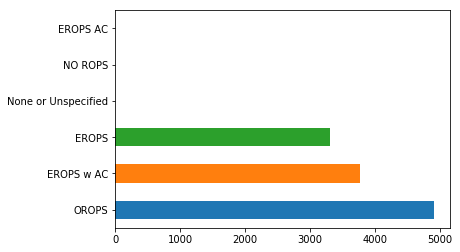

In [17]:
x.Enclosure.value_counts().plot.barh();

#### Calculating mean through the categorical variable

In [18]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
# Making a table of above 4 fields, and grouping it by Enclosure column
# then calculate mean of groups
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.841357,0.274503
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.577750,0.260626
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.689112,0.223437


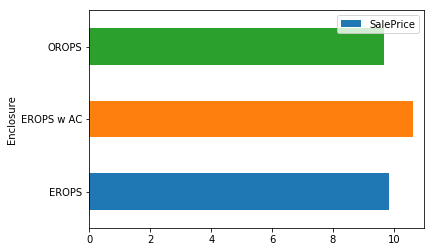

In [19]:
# Now plotting the means of Ground Truth
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

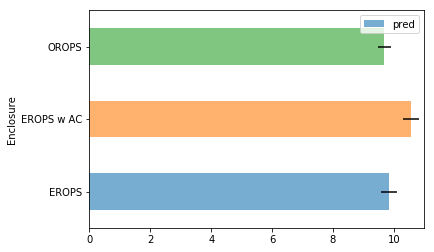

In [20]:
# Now plotting the means of Preditions
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

OROPS has a lower std as the number of samples are less in the dataset

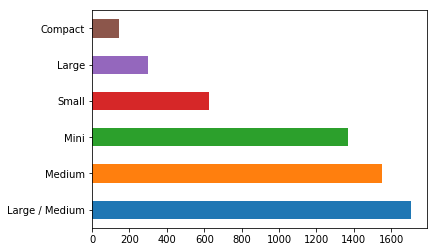

In [21]:
# Now trying the same for Product Size
raw_valid.ProductSize.value_counts().plot.barh();

In [22]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.857006,0.338237
Large,10.470589,10.377966,0.359974
Large / Medium,10.691871,10.656184,0.289165
Medium,10.681511,10.618261,0.284080
Mini,9.535147,9.562784,0.247902
Small,10.324448,10.327511,0.307557


In [23]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.034686
Compact           0.034314
Small             0.029780
Large / Medium    0.027136
Medium            0.026754
Mini              0.025924
dtype: float64

So probably this technique is to understand on what sort of data does our model do better and worse.
But this is done for specific features, to find out which features to look into, we need to know the important features.

## Trying feature importance

In [25]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.175111
37,Coupler_System,0.128929
13,ProductSize,0.103550
14,fiProductClassDesc,0.082860
2,ModelID,0.054275
63,saleElapsed,0.050082
10,fiSecondaryDesc,0.042760
38,Grouser_Tracks,0.041821
19,Enclosure,0.037104
8,fiModelDesc,0.030577


In [26]:
??rf_feat_importance

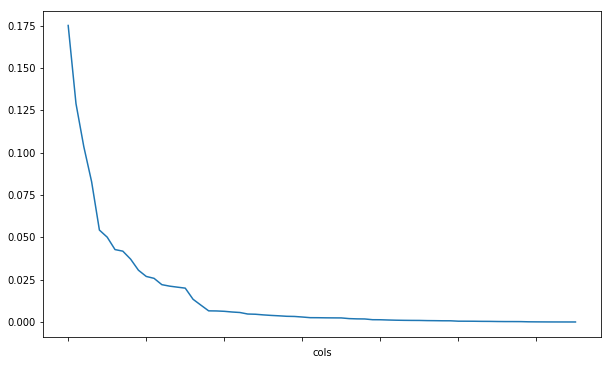

In [27]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [28]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

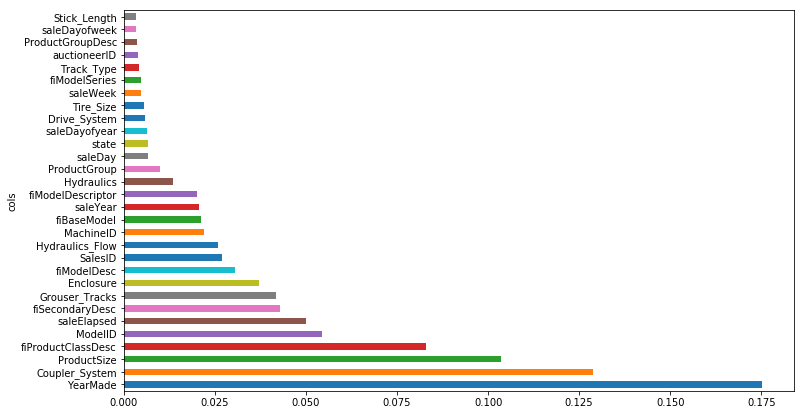

In [29]:
plot_fi(fi[:30]);

In [30]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

23

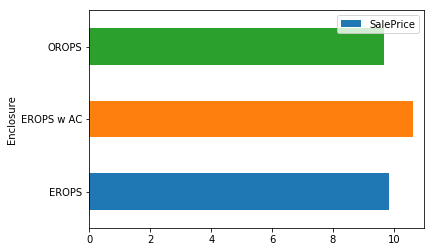

In [31]:
?df_trn.plot
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

Shows one variable less than lesson notebook, find the bug

#### Tried to scatter plot YearMade vs Sales Price, but a lot of YearMade values are 1000. 

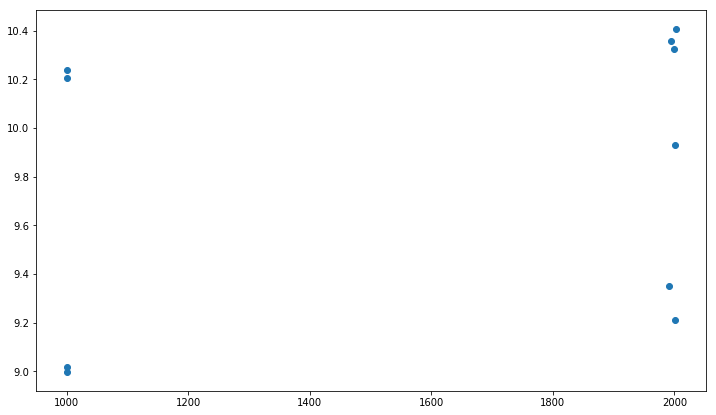

In [74]:
plt.figure(figsize=(12,7))
plt.scatter(pdf_trn['YearMade'].values[:10], py_trn[:10])

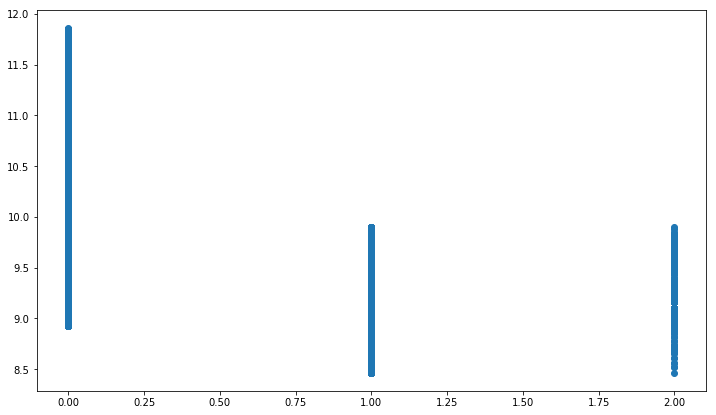

In [81]:
plt.figure(figsize=(12,7))
plt.scatter(pdf_trn['Coupler_System'].values, py_trn)

In [75]:
pdf_trn['YearMade'].values[:10]

array([2001, 1991, 1995, 2001, 1000, 2000, 1000, 1000, 2002, 1000])

In [76]:
df_raw['YearMade'].values[:10]

array([2004, 1996, 2001, 2001, 2007, 2004, 1993, 2001, 2008, 1000])

In [77]:
df_raw_pure = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In [82]:
df_raw_pure['YearMade'].values[:10]

array([2004, 1996, 2001, 2001, 2007, 2004, 1993, 2001, 2008, 1000])